# Python On Resonance (PyOR)
## Everybody can simulate NMR

Author: Vineeth Thalakottoor 

Email: vineethfrancis.physics@gmail.com

## Tutorial 8: Insensitive Nuclei Enhanced by Polarization Transfer (INEPT)
Till now we have seen how to make spin operators to evolution of density matrix using PyOR. Lets start simulating some basic NMR experiments. We begin with INEPT.  

I will follow mostly book "NMR: The Toolkit, How Pulse Sequences Work" by P.J Hore, J.A. Jones and S. Wimperis

## Load Python packages and define path to the source file "PythonOnResonance.py"

In [1]:
pathSource = '/media/HD2/Vineeth/PostDoc_Simulations/Github/PyOR_G/Source'

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import sys
sys.path.append(pathSource)

import PythonOnResonance as PyOR

import time
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib notebook
import sympy as sp
from sympy import *
from IPython.display import display, Math, Latex

## Generating Spin System

In [3]:
"""
Define Spin quantum numbers of your spins in "Slist1".
Slist1[0] is spin of first particle and Slist1[1] is spin of second particle.
""";

Slist1 = [1/2,1/2]

In [4]:
"""
Define Planck constant equals 1. 
Because NMR spectroscopists are more interested to write Energy in frequency units. 
if False then hbarEQ1 = hbar
""";

hbarEQ1 = True

In [5]:
"""
Generate Spin Operators
""";

System = PyOR.Numerical_MR(Slist1,hbarEQ1)

"""
Sx, Sy and Sz Operators
""";
Sx,Sy,Sz = System.SpinOperator()

"""
S+ and S- Operators
""";
Sp,Sm = System.PMoperators(Sx,Sy)

## Zeeman Hamiltonian in Lab Frame

In [6]:
"""
Gyromagnetic Ratio
Gamma = [Gyromagnetic Ratio spin 1, Gyromagnetic Ratio spin 1, ...]
""";
Gamma = [System.gammaH1,System.gammaC13]

"""
Define the field of the spectromter, B0 in Tesla.
"""
B0 = 9.4

"""
Define the chemical Shift of individual spins
Offset = [chemical Shift spin 1, chemical Shift spin 1, ..]
"""
Offset = [0,50] # Offset frequency in Hz

"""
Function "LarmorF" give the list Larmor frequencies of individual spins in lab frame
"""
LarmorF = System.LarmorFrequency(Gamma,B0,Offset)

Hz = System.Zeeman(LarmorF,Sz)

Larmor Frequency in MHz:  [-400.22801765 -100.65891793]


## Initialize Density Matrix

In [7]:
"""
We will generate Initial Density Matrix in two ways: 
First we will generate a density matrix as we prefer say, Sz. 
Second we will create density matrix at thermal equlibrium

First Case
""";

Thermal_DensMatrix = True 

if Thermal_DensMatrix:
    Hz_EnUnit = System.Convert_FreqUnitsTOEnergy(Hz)
    HT_approx = False # High Temperature Approximation is False
    T = 300 # Temperature in Kelvin
    rho_in = System.EqulibriumDensityMatrix(Hz_EnUnit,T,HT_approx)
    rhoeq = rho_in.copy()   
else:
    rho_in = np.sum(Sz,axis=0) # Initial Density Matrix
    rhoeq = np.sum(Sz,axis=0)  # Equlibrium Density Matrix   
    print("Trace of density metrix = ", np.trace(rho_in))

Trace of density metrix =  1.0


In [8]:
'''
Operator Basis
Option: 'Cartesian spin half' and 'PMZ spin half'
All the 16 operator basis are loaded in the matrix, 'B_car'
''';
Basis = 'Cartesian spin half'
B_car = System.TwoSpinOP(Sx,Sy,Sz,Sp,Sm,Basis)

<IPython.core.display.Latex object>

In [9]:
'''
B_car[0] = B0 = 1/2 E,
B_car[1] = B1 = Ix,
so on...
Hope you understand.
'''
System.OperatorBasis('Cartesian')

<IPython.core.display.Latex object>

In [10]:
Population_H1 = System.OP_InnerProduct(B_car[3],rho_in)
Population_C13 = System.OP_InnerProduct(B_car[6],rho_in)
print("Polation diference two states of Proton = ",Population_H1)
print("Polation diference two states of Carbon = ",Population_C13)
print("Ratio of Population_H1 and Population_C13 = ",(Population_H1/Population_C13).real)

Polation diference two states of Proton =  (1.6005440617722355157e-05+0j)
Polation diference two states of Carbon =  (4.0254311617637927867e-06+0j)
Ratio of Population_H1 and Population_C13 =  3.9760810642478784946


## Zeeman Halitonian in Rotating Frame

In [11]:
OmegaRF = [-System.gammaH1*B0,-System.gammaC13*B0]
Hzr = System.Zeeman_RotFrame(LarmorF, Sz, OmegaRF)

## J Coupling Hamiltonian

In [12]:
"""
Define J Coupling between each spins, Jlist[0][3] means J coupling between 1st spin and 4th spin.
"""

Jlist = np.zeros((len(Slist1),len(Slist1)))
Jlist[0][1] = 150

Hj = System.Jcoupling_Weak(Jlist,Sz)

## Relaxation Constant

In [13]:
'''
Define longitudinal (R1) and transverse Relaxation (R2)
''';

R1 = 1.0
R2 = 2.0
System.Relaxation_Constants(R1,R2)

'''
Options for "Rprocess": "No Relaxation" or "Phenomenological" 
                         or "Random Field Fluxtuation" or "Dipolar"
''';
Rprocess = "No Relaxation"

## Pulse 90x on Carbon

In [14]:
pulse_angle = 90.0
rho = System.Rotate_H(rho_in,pulse_angle,Sx[1]) 

## Detect Carbon

In [15]:
dt = 1.0e-4
fs = 1.0/dt
AQ = 5.0
Npoints = int(AQ/dt)
print("Number of points in the simulation", Npoints)

"""
option for solver, "method": "Unitary Propagator" or "ODE Solver"
"""
method = "Unitary Propagator"

start_time = time.time()
t, rho_t = System.Evolution_H(rhoeq,rho,Sx,Sy,Sz,Sp,Sm,Hzr + Hj,dt,Npoints,method,Rprocess)
end_time = time.time()
timetaken = end_time - start_time
print("Total time = %s seconds " % (timetaken))

Exp_C13 = B_car[4] + 1j * B_car[5]
t, Mt_C13_normal = System.Expectation_H(rho_t,Exp_C13,dt,Npoints)

Number of points in the simulation 50000
Total time = 0.3463256359100342 seconds 


## INEPT

In [16]:
delta = 1/(4*Jlist[0][1])
def INEPT(rho_in,rhoeq,delta,dt,AQ):
    
    # 90x pulse on H1
    rho = System.Rotate_H(rho_in,90,Sx[0])
    
    # First delta 
    method = "Unitary Propagator"
    Npoints = int(delta/dt)
    t, rho_t = System.Evolution_H(rhoeq,rho,Sx,Sy,Sz,Sp,Sm,Hzr + Hj,dt,Npoints,method,Rprocess)
    
    # 180y on H1
    rho = System.Rotate_H(rho_t[-1],180,Sy[0])
    
    # 180y on C13
    rho = System.Rotate_H(rho,180,Sy[1])
    
    # Second delta
    t, rho_t = System.Evolution_H(rhoeq,rho,Sx,Sy,Sz,Sp,Sm,Hzr + Hj,dt,Npoints,method,Rprocess)
    
    # 90y on H1
    rho = System.Rotate_H(rho_t[-1],90,Sy[0])
    
    # 90x on C13
    rho = System.Rotate_H(rho,90,Sx[1])
    
    # Detect C13
    Npoints = int(AQ/dt)
    t, rho_t = System.Evolution_H(rhoeq,rho,Sx,Sy,Sz,Sp,Sm,Hzr + Hj,dt,Npoints,method,Rprocess)
    Exp_C13 = B_car[4] + 1j * B_car[5]
    t, Mt_C13 = System.Expectation_H(rho_t,Exp_C13,dt,Npoints)
    return t, Mt_C13  

start_time = time.time()
t, Mt_C13 = INEPT(rho_in,rhoeq,delta,dt,AQ)
end_time = time.time()
timetaken = end_time - start_time
print("Total time = %s seconds " % (timetaken))

Total time = 0.5433545112609863 seconds 


## Windowing

In [17]:
Mt_C13_normal = System.WindowFunction(t,Mt_C13_normal,5.0)
Mt_C13 = System.WindowFunction(t,Mt_C13,5.0)

## Fourier Transform

In [18]:
fs = 1.0/dt
freq, spectrum_normal = System.FourierTransform(Mt_C13_normal,fs,5)
freq, spectrum_inept = System.FourierTransform(Mt_C13,fs,5)

## Plotting

<IPython.core.display.Javascript object>


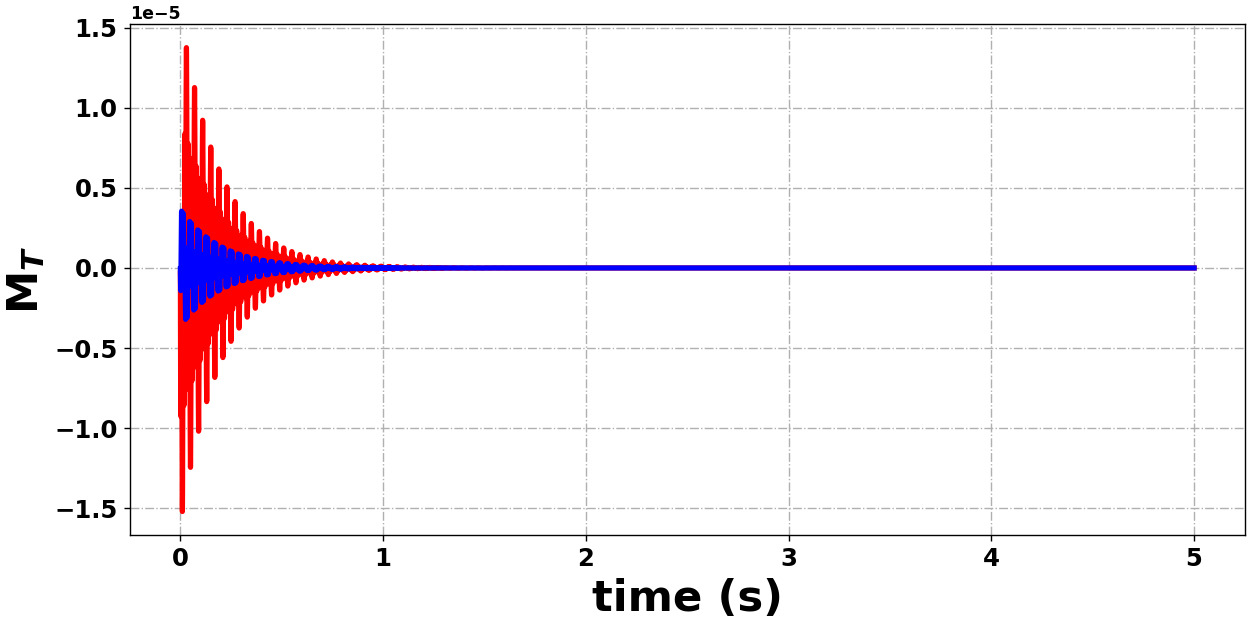

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


In [19]:
'''
Red: INEPT
Blue: Normal (90deg pulse and detect C13)
''';
System.PlottingMulti(3,[t,t],[Mt_C13,Mt_C13_normal],"time (s)",R"M$_{T}$",["red","blue"])

<IPython.core.display.Javascript object>


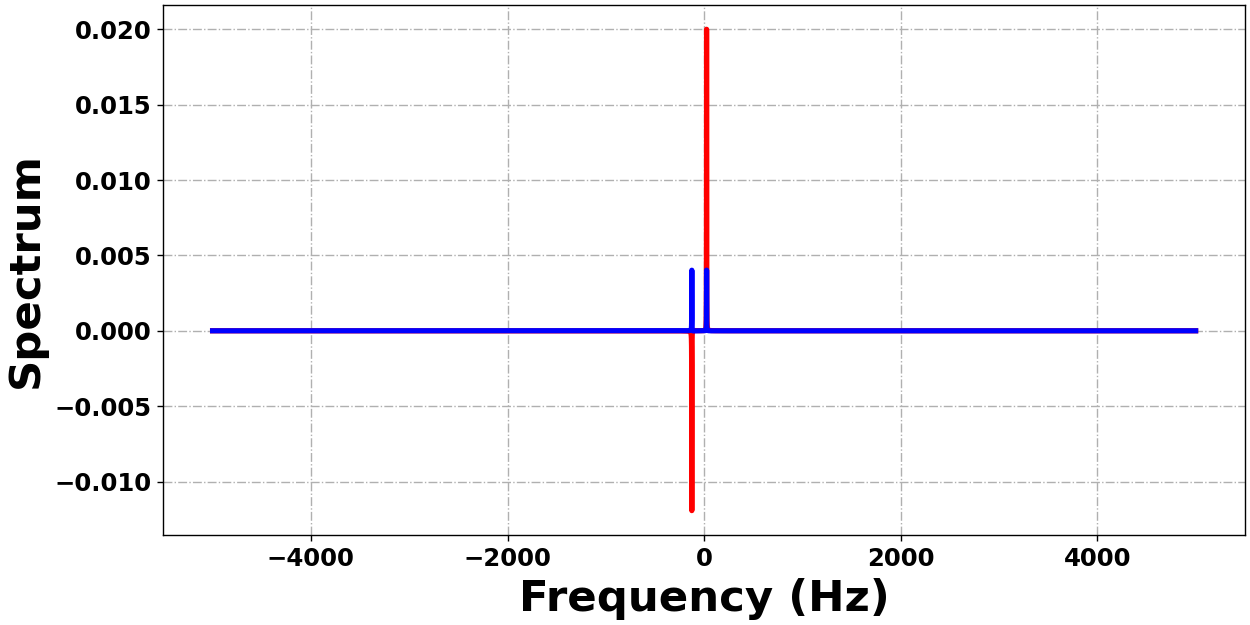

/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/opt/anaconda3/lib/python3.9/site-packages/numpy/core/_asarray.py:102: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
No handles with labels found to put in legend.


In [20]:
'''
Red: INEPT
Blue: Normal (90deg pulse and detect C13)
Remark: The enhancement factor is almost 4
''';
Spectrum_inept_PH0 = System.PhaseAdjust_PH0(spectrum_inept,-45.0)
Spectrum_normal_PH0 = System.PhaseAdjust_PH0(spectrum_normal,45.0)
System.PlottingMulti(4,[freq,freq],[Spectrum_inept_PH0,Spectrum_normal_PH0],"Frequency (Hz)","Spectrum",["red","blue"])

## Next tutorial: COSY

## Any suggestion? write to me
If you see something is wrong please write to me, so that the PyOR can be error free. 

vineethfrancis.physics@gmail.com